# Init

In [1]:
using LinearAlgebra
using NearestNeighbors
using StaticArrays
using Luxor
include("utils.jl"   )
include("kernels.jl" );

# Problem Domain

In [2]:
_DIM_X    = 4
_DIM_A    = 1

Fmax      = 10.0 #7.5 #15.0 #25.0 #5.0 #10.0 #20.0
Fdiv      =  4.0 # Divisor for force ctrl resolution

_X_DOMAIN = [ -30.0 +30.0 ; # thetaDotDot
              -15.0 +15.0 ; # thetaDot
              -20.0 +20.0 ; # theta
              -10.0 +10.0 ] # xDot
_A_DOMAIN = [ -Fmax +Fmax ]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10;

nX = _DIM_X; # ---- State    dims
nA = _DIM_A; # ---- Action   dims
nQ = nX + nA; # --- Combined dims
X  = zeros( nX ); # Current position
A  = zeros( nA ); # Current effort
Q  = zeros( nQ ); # Current Q state

include("env_cartpole.jl");

In [3]:
"""
Assemble <State,Action> into Q-state
"""
function get_Q( X, A )
    res = zeros( nQ );
    res[ 1:nX ] = X[:];
    if typeof( A ) == Float64
        res[ nX+1 ] = A;
    else
        res[ nX+1:nQ ] = A;
    end
    return res;
end


"""
Disassemble <State,Action> into Q-state
"""
function XA_from_Q( Q )
    return Q[ 1:nX ], Q[ nX+1:nQ ];
end

"""
Select the relvant variables from the state vector
"""
function select_X_vector( Xbig )
    return [ Xbig[1], Xbig[2], Xbig[3], Xbig[5] ]
end

select_X_vector

# Agent

## Agent Structures

In [4]:
# Construct grid of anchors

Fres = Fmax/Fdiv
# Fres = 2.0 #7.5

# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 1.0, 1.0, 1.0, 1.0, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 2.0, 2.0, 2.0, 2.0, Fres ] );
G    = regular_grid_pts_nD( _Q_DOMAIN, [ 4.0, 4.0, 4.0, 4.0, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 7.5, 7.5, 7.5, 7.5, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 12.0, 8.0, 12.0, 8.0, Fres ] );
nPts = size( G )[2]; # - Number of anchors
mDim = size( G )[1]; # - Dimensionality of anchors 
V    = zeros(Float64, nPts); # Values at anchors
VS   = zeros(Float64, nPts); # Scratch values
vSwp = zeros(Float64, nPts); # Swap values
vBst = zeros(Float64, nPts); # Best values
vsts = zeros(Int64, nPts); # - Set number of visits to zero
vAcc = zeros(Float64, nPts); # Accumulated value per point per iteration
println( size( G ) )

# Construct spatial trees over anchors (WITHOUT reordering!)
Q_kdTree = KDTree( G            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
X_kdTree = KDTree( G[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
Q_blTree = BallTree( G             ); 
X_blTree = BallTree( G[1:_DIM_X,:] ); 

(5, 76032)


## Agent Params

In [5]:
##### Params #####
scale = 7.0;
vNN   = 3;
rad   = scale;
N_scl = 1.0;

@assert Fres < scale "!! `scale` SET TOO LOW !!"

## Helper Functions

In [6]:
"""
Fetch all the anchor indices that have a visit count of at least 1
"""
function fetch_visted_indices( visitArr )
    rtnDxs = []
    nPts   = size( visitArr, 1 )
    for j = 1:nPts
        if visitArr[j] >= 1
            append!( rtnDxs, j )
        end
    end
    return rtnDxs
end


"""
Set all anchor visits to zero
"""
function empty_visited_arr( visitArr )
    return zeros(Int64, size( visitArr ) ); 
end


"""
Reward high speed at the bottom and low speed at the top
"""
function cartpole_reward( X )
    
    # 0. Set limits
    maxThetaDot =  10.0
    maxX        =   2.0
    # 1. Set weights
    thFactor    = 100.0
    thDotFactor =   8.0
    
    # 2. Unpack & Normalize state
    thetaDotN   = abs( X[2] ) # ----- Angular velocity
    thetaN      = X[3] # Angle
    xN          = abs( X[6] ) # ----- Fulcrum position
    # 3. Reward high speed at the bottom and low speed at the top
    R = thFactor*cos(thetaN) - thDotFactor*cos(thetaN)*(thetaDotN)
    
    
    if xN > maxX
        R -= xN
    end
    # if thetaDotN > maxThetaDot
    #     R -= thetaDotN
    # end
    return R
end


"""
Given a state `X`, determine the best action
"""
function optimal_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   = 0.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = cartpole_reward( Xp )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state_knn( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_w_knn( Q_kdTree, G, V, get_Q( select_X_vector( Xp ), A ); k = vNN )
        if (Ra != 0.0) && (Ra > bestR)
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state_rad( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        
        # Ra = query_value_w_knn( Q_kdTree, G, V, get_Q( select_X_vector( Xp ), A ); k = vNN )
        Ra = query_store_w_radius( Q_blTree, G, V, get_Q( select_X_vector( Xp ), A ); radius = rad )
        
        if (Ra != 0.0) && (Ra > bestR)
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state_gauss( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        
        # Ra = query_value_w_knn( Q_kdTree, G, V, get_Q( select_X_vector( Xp ), A ); k = vNN )
        # Ra = query_store_w_radius( Q_blTree, G, V, get_Q( select_X_vector( Xp ), A ); radius = rad )
        Ra = query_value_w_gauss( Q_blTree, G, V, get_Q( select_X_vector( Xp ), A ); scale = scale, lim = N_scl )
        
        if (Ra != 0.0) && (Ra > bestR)
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end

# println( typeof( vsts ) )

learned_action_for_state_gauss

# Optimal Agent

In [7]:
dur_s     = 40
ts        = 0.01
T         = Int64((1/ts)*dur_s)
N_0       = N_cart( 0.0, 0.0, pi/2.0 )
X_0       = [ 0.0, 0.0, pi, 0.0, 0.0, 10.0 , N_0 ]
states    = zeros( size( X_0, 1 ), T )
actions   = zeros( T );
bestXs    = zeros( size( X_0, 1 ), T )
bestAs    = zeros( T );

In [8]:
vSwp = zeros(Float64, nPts); # Swap values
vBst = zeros(Float64, nPts); # Best values
vBAv = zeros(Float64, nPts); # Values for best average
vBlA = zeros(Float64, nPts); # Values for best average
vAll = zeros(Float64, nPts); # Absorbs all training

In [9]:
gamma     = 0.950 #0.750 #0.950 #0.990; 
beta      = 1 / (1.0-gamma); 
epsMin    = 0.05 # 0.05
epsMax    = 0.50 #0.50 #0.15 #0.50 # 0.3 # 0.75 # 1.00
episodes  =  64 #2048 #1024 #128 #512 #256 #20 # 160 # 40 # 80
epochs    =  64
aMargin   = (pi/180)*15.0
EXPrand   = 1.00 #0.25 #0.5 # 0.75
bgn       = time()
bestScore = -100.0;
bestAvg   = -100.0;
averages  = []

for m = 1:epochs
    
    println( "\nEpoch ", m, ", Best Score: ", bestScore, ", Best Average: ", bestAvg )
    
    # V = copy( vBst )
    
    epsilon = epsMax 
    deltaEp = (epsMax - epsMin)/episodes
    s_Totl  = 0.0
    
    for l = 1:episodes
        X       = X_0
        # epsilon = epsMax * (1 - (l-1)/episodes)
        
        
        for k = 1:T
        
            # 1. Cache last state
            qLast = get_Q( select_X_vector( X ), A )
            
            # 2. Choose action
            if rand() < epsilon
                
                if rand() < EXPrand 
                    A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                else
                    A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                end
            else

                # A = learned_action_for_state_knn( X, _A_DOMAIN, [ Fres ], ts )
                # A = learned_action_for_state_rad( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                A = learned_action_for_state_gauss( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                
                if A == 1000.0 # Indicates no values in this region
                    if rand() < EXPrand 
                        A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                    else
                        A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                    end
                end

            end

            # 3. Generate the next stae
            Xp = cartpole_dyn( X, A, ts )

            # 4. Collect reward R( s, a, s' )
            R_t = cartpole_reward( Xp )

            # 5. Get the optimal action at the next state
            a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fres ], ts )

            # 6. Compute the value at the next state
            
            # V_tp1_opt = query_value_w_knn( Q_kdTree, G, V, get_Q( select_X_vector( Xp ), a_tp1_opt ); k = vNN )
            # V_tp1_opt = query_store_w_radius( Q_blTree, G, V, get_Q( select_X_vector( Xp ), a_tp1_opt ); radius = rad )
            V_tp1_opt = query_value_w_gauss( Q_blTree, G, V, get_Q( select_X_vector( Xp ), a_tp1_opt ); scale = scale, lim = N_scl )


            # 7. Find the local neighborhood of anchors within `h` radius of the last state
            idxs  = inrange( X_blTree, select_X_vector( X ), scale )
            nBall = size( idxs, 1 )

            # 8. For each anchor whose ball encloses the last state
            for i = 1:nBall 
                # 9. Fetch visits and calc learning rate
                j     = idxs[i]
                N_k   = vsts[j]
                eta_N = 1 / ( N_k + 1 )

                if N_k > 0
                    vAcc[j] = (1 - eta_N) * vAcc[j] + eta_N * ( R_t + gamma * V_tp1_opt )
                else
                    vAcc[j] = R_t + gamma * V_tp1_opt
                end

                vsts[j] += 1

            end

            # 10. Fetch visited
            # println( typeof( vsts ) )
            vDices = fetch_visted_indices( vsts )
            Nvst   = size( vDices, 1 )

            # 11. For each visited, blend accumulated value change into present value
            for k = 1:Nvst
                alpha_k = beta / (beta+k)
                j       = vDices[k]
                
                # V[j] = (1-alpha_k)*V[j] + alpha_k*vAcc[j]
                VS[j] = (1-alpha_k)*V[j] + alpha_k*vAcc[j]
                
            end

            # 12. Set up the next iteration
            vsts        = empty_visited_arr( vsts )
            states[:,k] = Xp
            actions[k]  = A
            X           = Xp
            
        end
        
        s_l    = vertical_score_s( states, aMargin, ts )
        s_Totl += s_l
        
        if s_l > bestScore
            bestScore = s_l
            bestXs    = copy( states  )
            bestAs    = copy( actions )
            vBst      = copy( V )
        end
        
        if l % 4 == 0
            println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        end
        
        epsilon -= deltaEp
        
        # if l%2 == 0
        #     vSwp = copy( VS   )
        #     VS   = copy( V    )
        #     V    = copy( vSwp )
        #     println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        # end
        
        vSwp = copy( VS   )
        VS   = copy( V    )
        V    = copy( vSwp )
        
        
    end
    
    s_Avg = s_Totl / episodes
    println( "Average Score: ", s_Avg )
    
    append!( averages, s_Avg )
    
    if s_Avg > bestAvg
        bestAvg = s_Avg
        vBAv    = copy( V ) # Try a blend of both next
        # vBlA    = blend_alpha_of_A_into_B( 0.50, VS, V )
    end
    
end


Epoch 1, Best Score: -100.0, Best Average: -100.0
Training Iteration 4 score: 0.0, epsilon: 0.47890625000000003
Training Iteration 8 score: 0.18000000000000002, epsilon: 0.4507812500000001
Training Iteration 12 score: 0.0, epsilon: 0.4226562500000001
Training Iteration 16 score: 0.0, epsilon: 0.39453125000000017
Training Iteration 20 score: 0.0, epsilon: 0.3664062500000002
Training Iteration 24 score: 0.0, epsilon: 0.33828125000000026
Training Iteration 28 score: 0.0, epsilon: 0.3101562500000003
Training Iteration 32 score: 0.0, epsilon: 0.28203125000000034
Training Iteration 36 score: 0.0, epsilon: 0.2539062500000004
Training Iteration 40 score: 0.0, epsilon: 0.22578125000000043
Training Iteration 44 score: 0.21000000000000005, epsilon: 0.19765625000000048
Training Iteration 48 score: 0.0, epsilon: 0.16953125000000052
Training Iteration 52 score: 0.0, epsilon: 0.14140625000000057
Training Iteration 56 score: 0.16, epsilon: 0.11328125000000058
Training Iteration 60 score: 0.0, epsilon

Saved a trained Q-table with size (76032,), After 599.5756454308828 minutes of training!


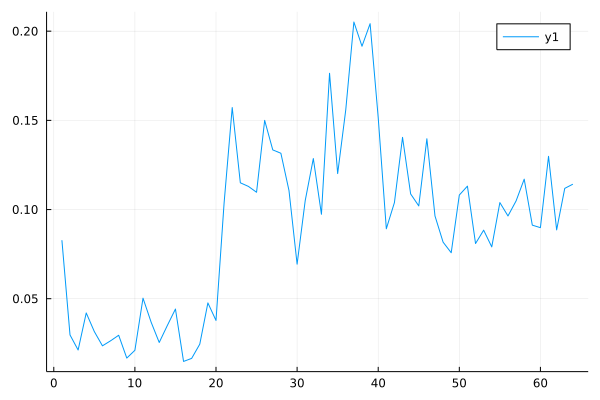

In [10]:
vTrn = copy( V )
println( "Saved a trained Q-table with size ", size( vTrn ), ", After ", (time()-bgn)/60.0, " minutes of training!" )

using Plots

plot( averages )

In [11]:
"""
Return fraction of elements that are nonzero
"""
function vector_fullness( vec )
    N = size( vec, 1 )
    c = 0
    for j = 1:N
        if vec[j] != 0.0
            c += 1
        end
    end
    return c/N
end

vector_fullness

In [12]:
vTrn = copy( V );

In [13]:
println( "Alternate Weights are ", vector_fullness( VS   ), " full" )
println( "Trained   Weights are ", vector_fullness( vTrn ), " full" )
println( "Best      Weights are ", vector_fullness( vBst ), " full" )

Alternate Weights are 0.8707386363636364 full
Trained   Weights are 0.8574810606060606 full
Best      Weights are 0.8578361742424242 full


# Optimal Iteration

In [14]:
"""
Use the desginated value table to navigate cartpole env
WARNING: This function OVERWRITES `V`!, so make sure to save the Q-tables that you need ELSEWHERE!!
"""
function optimal_cartpole_agent_P1_episode( Vfunc, T, X_0, ts, epsilon )
    global V
    
    # Init #
    V      = copy( Vfunc )
    record = zeros( size( X_0, 1 ), T ) # Recording of all system states
    X      = X_0 # ---------------------- Init state
    record[:,1] = X_0 # ----------------- Start recording
    
    # Iterate #
    for k = 2:T
        
        # 1. Choose an action
        if rand() < epsilon
            A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
        else
            
            # A = learned_action_for_state_knn( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
            # A = learned_action_for_state_rad( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
            A = learned_action_for_state_gauss( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
            
            if A == 1000.0 # Indicates no values in this region
                # A = optimal_action_for_state( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
            end
        end
        
        # 2. Cache last state
        qLast = get_Q( select_X_vector( X ), A )

        # 3. Generate the next stae
        Xp = cartpole_dyn( X, A, ts )

        # 4. Save data
        record[:,k] = Xp
        
        # 5. Prepare for next iteration
        X = Xp
    end
    return record
end

optimal_cartpole_agent_P1_episode

In [15]:
episodes = 20
scoreSum = 0.0
trials   = [ 0.05, 0.075, 0.0875, 0.10, 0.1125, 0.125, 0.15, 0.1625, 0.175, 0.1875, 0.20 ]  

for trlEps in trials
    
    scoreSum = 0.0
    
    for epNo = 1:episodes

        res = optimal_cartpole_agent_P1_episode( vTrn, T, X_0, ts, trlEps )
        s_e = vertical_score_s( res, aMargin, ts )
        scoreSum += s_e
        if epNo % 5 == 0
            println( "\tEp ", epNo, ", Score: ", s_e )
        end

    end
    println( "Average Trained Score (out of ", episodes, "): ", scoreSum/episodes, ", epsilon = ", trlEps, "\n" )
end

	Ep 5, Score: 0.08
	Ep 10, Score: 0.09
	Ep 15, Score: 0.23000000000000007
	Ep 20, Score: 0.18000000000000002
Average Trained Score (out of 20): 0.15000000000000005, epsilon = 0.05

	Ep 5, Score: 0.24000000000000007
	Ep 10, Score: 0.15
	Ep 15, Score: 0.24000000000000007
	Ep 20, Score: 0.3900000000000002
Average Trained Score (out of 20): 0.14750000000000002, epsilon = 0.075

	Ep 5, Score: 0.22000000000000006
	Ep 10, Score: 0.24000000000000007
	Ep 15, Score: 0.3100000000000001
	Ep 20, Score: 0.26000000000000006
Average Trained Score (out of 20): 0.16550000000000004, epsilon = 0.0875

	Ep 5, Score: 0.13999999999999999
	Ep 10, Score: 0.09999999999999999
	Ep 15, Score: 0.16
	Ep 20, Score: 0.0
Average Trained Score (out of 20): 0.17500000000000004, epsilon = 0.1

	Ep 5, Score: 0.15
	Ep 10, Score: 0.09999999999999999
	Ep 15, Score: 0.09999999999999999
	Ep 20, Score: 0.15
Average Trained Score (out of 20): 0.12350000000000003, epsilon = 0.1125

	Ep 5, Score: 0.22000000000000006
	Ep 10, Score: 

In [16]:
eps = 0.035


"""
Exchange nonzero values
"""
function exchange_nonzeros( A, B )
    rtnA = zeros( size(A, 1) )    
    rtnB = zeros( size(B, 1) )
    N    = size(A, 1)
    for j = 1:N
        
        # Handle A
        if A[j] == 0.0
            rtnA[j] = B[j]
        else
            rtnA[j] = A[j]
        end
        
        # Handle B
        if B[j] == 0.0
            rtnB[j] = A[j]
        else
            rtnB[j] = B[j]
        end
    end
    
    return rtnA, rtnB
end


if vertical_score_s( optimal_cartpole_agent_P1_episode( vBAv, T, X_0, ts, eps ), aMargin, ts ) > vertical_score_s( optimal_cartpole_agent_P1_episode( vBst, T, X_0, ts, eps ), aMargin, ts )
    println( "Chose vBAv as primary!" )
    vAug, _ = exchange_nonzeros( vBAv, vBst ) # LARGE improvement
else
    println( "Chose vBst as primary!" )
    vAug, _ = exchange_nonzeros( vBst, vBAv )
end


if vertical_score_s( optimal_cartpole_agent_P1_episode( VS, T, X_0, ts, eps ), aMargin, ts ) > vertical_score_s( optimal_cartpole_agent_P1_episode( vTrn, T, X_0, ts, eps ), aMargin, ts )
    println( "Chose VS as secondary!" )
    vAug, _ = exchange_nonzeros( vAug, VS )
    vAug, _ = exchange_nonzeros( vAug, vTrn )
else
    println( "Chose vTrn as secondary!" )
    vAug, _ = exchange_nonzeros( vAug, vTrn )
    vAug, _ = exchange_nonzeros( vAug, VS )
end

episodes = 100
scoreSum = 0.0
trials   = [ 0.00, 0.01, 0.025, 0.05, 0.0625, 0.075, 0.0875, 0.10, 0.125, 0.1375, 0.15, 0.1625, 0.175, 0.1875, 0.20 ]  

for trlEps in trials
    
    scoreSum = 0.0
    
    for epNo = 1:episodes

        res = optimal_cartpole_agent_P1_episode( vAug, T, X_0, ts, trlEps )
        s_e = vertical_score_s( res, aMargin, ts )
        scoreSum += s_e
        if epNo % 10 == 0
            println( "\tEp ", epNo, ", Score: ", s_e )
        end

    end
    println( "Average vAug Score (out of ", episodes, "): ", scoreSum/episodes, ", epsilon = ", trlEps, "\n" )
end

Chose vBst as primary!
Chose VS as secondary!
	Ep 10, Score: 0.9500000000000006
	Ep 20, Score: 0.0
	Ep 30, Score: 0.0
	Ep 40, Score: 0.46000000000000024
	Ep 50, Score: 0.0
	Ep 60, Score: 1.270000000000001
	Ep 70, Score: 0.0
	Ep 80, Score: 0.0
	Ep 90, Score: 0.0
	Ep 100, Score: 1.2000000000000008
Average vAug Score (out of 100): 0.21600000000000016, epsilon = 0.0

	Ep 10, Score: 0.0
	Ep 20, Score: 0.17
	Ep 30, Score: 0.5700000000000003
	Ep 40, Score: 0.0
	Ep 50, Score: 0.0
	Ep 60, Score: 0.25000000000000006
	Ep 70, Score: 0.0
	Ep 80, Score: 0.25000000000000006
	Ep 90, Score: 0.0
	Ep 100, Score: 0.0
Average vAug Score (out of 100): 0.20149999999999998, epsilon = 0.01

	Ep 10, Score: 0.0
	Ep 20, Score: 0.0
	Ep 30, Score: 0.21000000000000005
	Ep 40, Score: 0.0
	Ep 50, Score: 0.0
	Ep 60, Score: 0.3000000000000001
	Ep 70, Score: 0.0
	Ep 80, Score: 0.5900000000000003
	Ep 90, Score: 0.36000000000000015
	Ep 100, Score: 0.2700000000000001
Average vAug Score (out of 100): 0.23370000000000007, eps

In [17]:
episodes = 100
scoreSum = 0.0
trials   = [ 0.00, 0.01, 0.025, 0.05, 0.0625, 0.075, 0.0875, 0.10, 0.125, 0.1375, 0.15, 0.1625, 0.175, 0.1875, 0.20 ]  

for trlEps in trials
    
    scoreSum = 0.0
    
    for epNo = 1:episodes

        res = optimal_cartpole_agent_P1_episode( vBst, T, X_0, ts, trlEps )
        s_e = vertical_score_s( res, aMargin, ts )
        scoreSum += s_e
        if epNo % 10 == 0
            println( "\tEp ", epNo, ", Score: ", s_e )
        end

    end
    println( "Average Best Score (out of ", episodes, "): ", scoreSum/episodes, ", epsilon = ", trlEps, "\n" )
end

	Ep 10, Score: 0.4400000000000002
	Ep 20, Score: 0.3900000000000002
	Ep 30, Score: 0.23000000000000007
	Ep 40, Score: 0.23000000000000007
	Ep 50, Score: 0.18000000000000002
	Ep 60, Score: 0.0
	Ep 70, Score: 0.0
	Ep 80, Score: 0.15
	Ep 90, Score: 0.19000000000000003
	Ep 100, Score: 0.0
Average Best Score (out of 100): 0.22500000000000017, epsilon = 0.0

	Ep 10, Score: 0.0
	Ep 20, Score: 0.37000000000000016
	Ep 30, Score: 0.0
	Ep 40, Score: 0.0
	Ep 50, Score: 0.0
	Ep 60, Score: 0.0
	Ep 70, Score: 0.25000000000000006
	Ep 80, Score: 0.9000000000000006
	Ep 90, Score: 0.3100000000000001
	Ep 100, Score: 0.0
Average Best Score (out of 100): 0.2725000000000002, epsilon = 0.01

	Ep 10, Score: 0.0
	Ep 20, Score: 0.12999999999999998
	Ep 30, Score: 0.0
	Ep 40, Score: 0.49000000000000027
	Ep 50, Score: 0.0
	Ep 60, Score: 0.0
	Ep 70, Score: 0.35000000000000014
	Ep 80, Score: 0.0
	Ep 90, Score: 0.6600000000000004
	Ep 100, Score: 0.0
Average Best Score (out of 100): 0.17970000000000008, epsilon = 0.025

┌ Info: Frames for animation "test" are being stored in directory: 
│ 	 /tmp/jl_PAS2t9
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:195
┌ Info: ... 1334 frames saved in directory:
│ 	 /tmp/jl_PAS2t9
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:217
┌ Info: GIF is: /tmp/jl_PAS2t9/test.gif
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:246


Luxor.AnimatedGif("/tmp/jl_PAS2t9/test.gif")
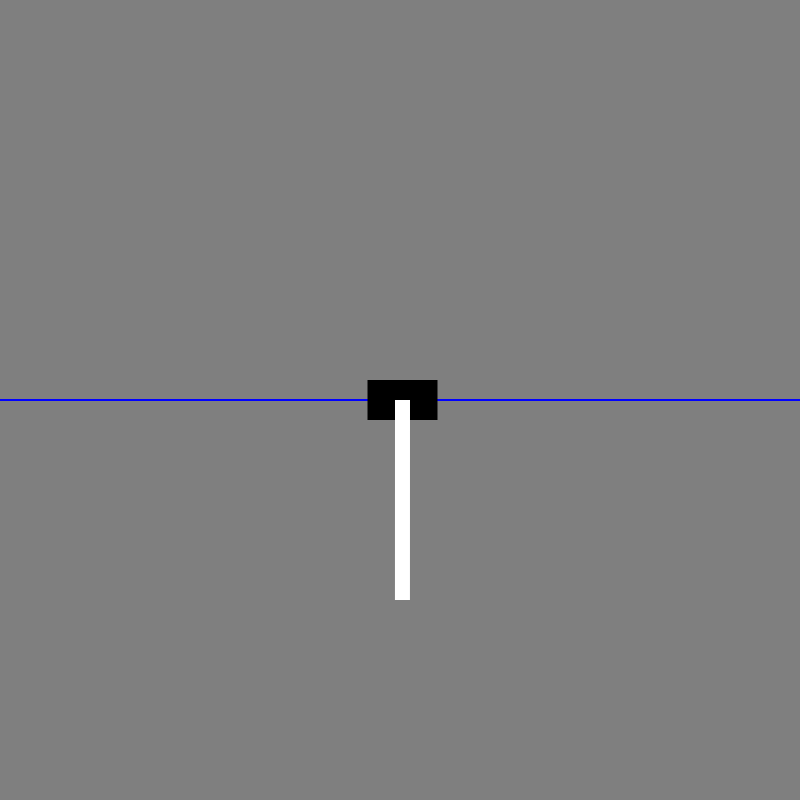

In [18]:
render_cartpole_episode( bestXs, ts )

In [19]:
bestScore

1.8300000000000014

# Spare Parts

## Corpus Learning Iteration

In [20]:
"""
One learning step from one predefined Q-state
"""
function corpus_iteration( X, A, ts )
    global vsts, G, V, vAcc
    
    # 1. 
    
    # 2. Cache last state
    qLast = get_Q( select_X_vector( X ), A )
    
    # 3. Generate the next stae
    Xp = cartpole_dyn( X, A, ts )
    
    # 4. Collect reward R( s, a, s' )
    R_t = cartpole_reward( Xp )
    
    # 5. Get the optimal action at the next state
    a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fmax/Fdiv ], ts )
    
    # 6. Compute the value at the next state
    V_tp1_opt = query_value_w_knn( Q_kdTree, G, V, get_Q( select_X_vector( Xp ), a_tp1_opt ); k = vNN )
    
    
    # 7. Find the local neighborhood of anchors within `h` radius of the last state
    idxs  = inrange( X_blTree, select_X_vector( X ), scale )
    nBall = size( idxs, 1 )
    
    # println( typeof( vsts ) )
    
    # 8. For each anchor whose ball encloses the last state
    for i = 1:nBall 
        # 9. Fetch visits and calc learning rate
        j     = idxs[i]
        N_k   = vsts[j]
        eta_N = 1 / ( N_k + 1 )
                
        if N_k > 0
            vAcc[j] = (1 - eta_N) * vAcc[j] + eta_N * ( R_t + gamma * V_tp1_opt )
        else
            vAcc[j] = R_t + gamma * V_tp1_opt
        end
        
        vsts[j] += 1
        
    end
    
    # 10. Fetch visited
    # println( typeof( vsts ) )
    vDices = fetch_visted_indices( vsts )
    Nvst   = size( vDices, 1 )
    
    # 11. For each visited, blend accumulated value change into present value
    for k = 1:Nvst
        alpha_k = beta / (beta+k)
        j       = vDices[k]
        V[j] = (1-alpha_k)*V[j] + alpha_k*vAcc[j]
    end
    
    # 12. Set up the next iteration
    vsts = empty_visited_arr( vsts )
    
end

# println( typeof( vsts ) )

corpus_iteration

# Generate Corpus

In [21]:
dur_s   = 40
ts      = 0.01
T       = Int64((1/ts)*dur_s)
N_0     = N_cart( 0.0, 0.0, pi/2.0 )
X_0     = [ 0.0, 0.0, pi, 0.0, 0.0, 10.0 , N_0 ]
pers    = [ 0.0625, 0.0702, 0.078, 0.0859, 0.0938, 0.11, 0.125, 0.1875, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0 ]
data    = zeros( size( pers, 1 ), size( X_0, 1 ), T )
acts    = zeros( size( pers, 1 ), T )
X       = X_0
i       = 0

if false
    for period in pers
        i += 1
        data[i,:,1] = X_0
        for j = 2:T
            t  = (j-1)*ts
            A  = -Fmax * cos( (t/period)*2*pi )
            Xp = cartpole_dyn( X, A, ts )
            data[i,:,j] = Xp 
            acts[i,j]   = A
            X = Xp
        end
    end
end

# println( typeof( vsts ) )

# Learn Corpus

In [22]:
if false

    i = 0
    for period in pers
        i += 1
        for j = 1:T
            X = data[i,:,j]
            A = acts[i,j]
            corpus_iteration( X, A, ts )
        end
        println( "Corpus Iteration ", i, " score: ", vertical_score_s( data[i,:,:], aMargin, ts ) )
    end
    
end